<a href="https://colab.research.google.com/github/saurabhbarge/CE888-7-SP/blob/main/TweetEval_Assignment2/HatesSpeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing all the Libraries**

In [53]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import re
import string
from wordcloud import WordCloud
from matplotlib import pyplot as plt 
%matplotlib inline
import seaborn as sns

In [54]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Reading the Hate Dataset Training Text file and Training Labels file**

In [55]:
def dataset_create(filepath_text,filepath_labels):
    with open(filepath_text) as data:
        read_text = data.read()

    with open(filepath_labels) as data:
        read_labels = data.read()   
    
    read_text = read_text.split("\n")
    read_labels = read_labels.split("\n")
    read_text = [x.lower() for x in read_text]  
    
    df = pd.DataFrame({'Text':read_text,'Labels':read_labels})
    return df

In [56]:
train_hate = dataset_create('/content/drive/MyDrive/hate/train_text.txt','/content/drive/MyDrive/hate/train_labels.txt')
val_hate = dataset_create('/content/drive/MyDrive/hate/val_text.txt','/content/drive/MyDrive/hate/val_labels.txt')
test_hate = dataset_create('/content/drive/MyDrive/hate/test_text.txt','/content/drive/MyDrive/hate/test_labels.txt')

In [57]:
stop_words = list(set(stopwords.words('english'))) # list of stop words

**Mapping Labels**

In [58]:
# df_hate['Hate_labels'] = df_hate['Hate_labels'].map({'0': 'not-hate', '1': 'hate'})

In [59]:
stemmer = PorterStemmer() # creating stemmer object

In [60]:
lemmatizer = WordNetLemmatizer() # creating lemmatizer object

**Pre-processing Function includes the following:**
**-removes punctuations**
**,removes digits**
**,removes word 'user' which is frequently used in the datasets**
**,removes stopwords**
**,performed stemming**
**,performed lemmatization**

In [61]:
def pre_processing(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', ' ', text)
    text = re.sub('@user','',text)
    text = ' '.join([x for x in word_tokenize(text) if x not in stop_words])
    text = ' '.join([stemmer.stem(x) for x in word_tokenize(text)])
    text = ' '.join([lemmatizer.lemmatize(x) for x in word_tokenize(text)])
    return text

**Function for removing Emojis**

In [62]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

**Cleaned Text**

In [63]:
# cleaning the train data
train_hate['Text'] = train_hate['Text'].apply(lambda x: pre_processing(x))
train_hate['Text'] = train_hate['Text'].apply(lambda x: remove_emoji(x))

#cleaning the validation data
val_hate['Text'] = val_hate['Text'].apply(lambda x: pre_processing(x))
val_hate['Text'] = val_hate['Text'].apply(lambda x: remove_emoji(x))

#cleaning the test data
test_hate['Text'] = test_hate['Text'].apply(lambda x: pre_processing(x))
test_hate['Text'] = test_hate['Text'].apply(lambda x: remove_emoji(x))

In [64]:
print(train_hate.shape) 
print(val_hate.shape)
print(test_hate.shape)

(9001, 2)
(1001, 2)
(2971, 2)


**Checking the count of Labels**

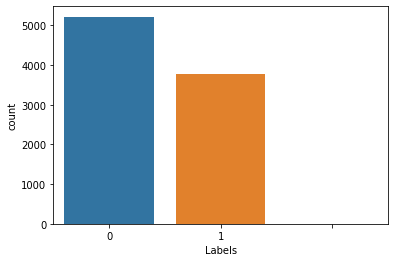

In [65]:
sns.countplot(x="Labels", data=train_hate)

**Checking for Missing Values**

In [66]:
train_hate.isna().sum()

Text      0
Labels    0
dtype: int64

**Using CountVectorizer and TF-IDF Vectorizer for translating text data into numeric form acceptable by the model**

In [67]:
cv = CountVectorizer(stop_words='english',max_features=10000)
cv_train_features = cv.fit_transform(train_hate['Text'])

In [68]:
cv_train_features

<9001x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 91158 stored elements in Compressed Sparse Row format>

In [69]:
tf = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tf_train_features = tf.fit_transform(train_hate['Text'])

In [70]:
tf_train_features

<9001x90155 sparse matrix of type '<class 'numpy.float64'>'
	with 203360 stored elements in Compressed Sparse Row format>

In [71]:
print('Bag of Words model:Train features shape:', cv_train_features.shape)
print('TFIDF model:> Train features shape:', tf_train_features.shape)

Bag of Words model:Train features shape: (9001, 10000)
TFIDF model:> Train features shape: (9001, 90155)


**WORD CLOUD**

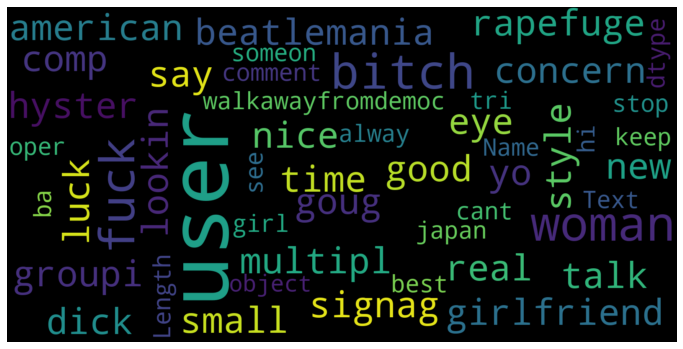

In [72]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(str(train_hate['Text']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [73]:
cv = CountVectorizer(stop_words='english',max_features=10000)
cv_test_features = cv.fit_transform(test_hate['Text'])

In [74]:
tf = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),sublinear_tf=True)
tf_test_features = tf.fit_transform(test_hate['Text'])

SVM

In [76]:
from sklearn import svm

In [77]:
clf = svm.SVC()

In [78]:
X_train = tf.transform(train_hate["Text"])
y_train = train_hate["Labels"]

In [79]:
X_test = tf.transform(test_hate["Text"])
y_test = test_hate["Labels"]

In [80]:
clf.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [81]:
preds = clf.predict(X_test)

In [82]:
print(f1_score(preds, y_test, average='macro'))
print(accuracy_score(preds,y_test))

0.38265923048742473
0.575563783237967


**FAST TEXT**

In [83]:
!pip install fasttext

In [113]:
import fasttext

In [114]:
with open('fasttext_hate_inputs.txt', 'w') as f:
    for each_text, each_label in zip(train_hate['Text'], train_hate['Labels']):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [115]:
classifier1 = fasttext.train_supervised('fasttext_hate_inputs.txt', lr=0.01, wordNgrams=2, epoch=100)

In [116]:
predictions1 = classifier1.predict(test_hate['Text'].to_list())
print(predictions1[0])

[['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__0'], ['__label__1'], ['__label__1'], ['__label__0'], ['__label__1'], ['__lab

In [117]:
def cleanpred_(text):
  return text[0].replace("__label__","")

In [118]:
fast_preds = map(cleanpred_,predictions1[0])
fast_preds = list(fast_preds)  # final predictions of fasttext model after cleaning
print(fast_preds)

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '1', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1',

In [119]:
f1_score(test_hate['Labels'],fast_preds,average='macro')

0.3157120949688161

In [121]:
accuracy_score(fast_preds,test_hate['Labels'])

0.5119488387748233

**ROBERTA-BASE**

In [92]:
!pip install transformers

In [93]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

In [94]:
task='hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [95]:
labels = ['0','1']

In [96]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [97]:
sents = list(test_hate['Text'][:])  # list of all texts
print(sents)

['user correct reid certainli weasel sadli weve got weasel user sen mcconnel user corrupt mueller investig wbe stop jobsmaga kag potu trump news voter nodaca usa', 'whoever unfollow bitch', 'user user peopl invad u bele right americafirst open hous ignor ye im christian nodaca', 'stop judg bitch cover ju cuz bad dont mean she catch shawdi could whore  da opposit keeper', 'knock head send gift wrap mom hous dumb raggedi bird bitch as hoe', 'user user user alway nodacai born usa usa first', 'user friend that blood brother bitch yo citi im hour away ill tomo…', 'user user muslim attack u kill subsequ allow muslim countrydo make sen youyou thank obama liber minion rino polit correct muslimban banislam travelban drainthedeepst deportthemal', 'user user like ever kept threat he lie usual buildthatwal', 'germani deserv call cuckland allow isi fighter refuge even rape underag girl yazidi girl scare forc see face rapistrefugeesnotwelcom appli scum', 'user user scrim whoever fuck want isnt fuck 

In [98]:
def get_preds(sentence):  # custom prediction function to extract the predicted labels
    text = sentence
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)  
    ranking = np.argsort(scores)
    ranking = ranking[::-1]

    dict1 = {}
    preds = []
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        # print(f"{i+1}) {l} {np.round(float(s), 4)}")
        dict1[l] = s
        pred = max(dict1, key=dict1.get)
        preds.append(pred)

    prediction = list(set(preds))

    return prediction 

In [99]:
result = map(lambda x: get_preds(x), sents)
roberta_preds = list(result)
roberta_preds = [item for sublist in roberta_preds for item in sublist] #final list of predictions

In [100]:
print("F1:score",f1_score(test_hate['Labels'],roberta_preds,average='macro'))
print("Accuracy:",accuracy_score(roberta_preds,test_hate['Labels']))


F1:score 0.4369361380433361
Accuracy: 0.6576910131268933


**RANDOM FOREST**

In [101]:
rf = RandomForestClassifier(n_estimators=500)

In [102]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [103]:
rf_preds = rf.predict(X_test)

In [104]:
print("F1:score:",f1_score(rf_preds,y_test,average='macro'))
print("Accuracy:",accuracy_score(rf_preds,y_test))

F1:score: 0.35733589039289876
Accuracy: 0.5425782564792999
